### Load Library

In [27]:
%matplotlib inline
import os
os.chdir("/Users/liyanran/Desktop/23Fall/STCS6701probML/probML6701/hw1/spatial_analysis_heat-main")

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import seaborn as sns
import pyreadr

### Load Data

In [28]:
#ts = pyreadr.read_r("./ts_heatindex_heatwarnings_byFIPS_2006_2016.RDS")
ts_geo = pyreadr.read_r("./ts_geo.RDS")
ts = ts_geo[None]
print(ts.head())

  StateCounty_FIPS  HImaxF_PopW  alert  weekday          X          Y  month
0            01001    81.951271    0.0      0.0 -86.642743  32.534921    4.0
1            01001    85.977650    0.0      0.0 -86.642743  32.534921    4.0
2            01001    82.727648    0.0      1.0 -86.642743  32.534921    4.0
3            01001    72.847272    0.0      1.0 -86.642743  32.534921    4.0
4            01001    76.618135    0.0      1.0 -86.642743  32.534921    4.0


In [29]:
# select columns
ts = ts[['HImaxF_PopW', 'weekday', "X", "Y", "month", 'alert']]

In [49]:
def zscore(x, lognorm=False, EPS=1e-8):
    # robust zscore
    if lognorm:
        x = np.log(x)
    x = x - x.median()  # copy
    x /= np.abs(x).median() * 1.4826 + EPS
    x.clip(-3, 3, inplace=True)
    x -= x.mean()
    x /= x.std(ddof=0) + EPS
    return x


def onehot(x, features):
    # one hot encoding with 0/1(no true false)
    for feat in features:
        dummies = pd.get_dummies(x[feat], prefix=feat, drop_first=False)
        x = pd.concat([x, dummies], axis=1)
        x = x.drop(feat, axis=1)
    return x


def preprosess(data):
    feat = ["HImaxF_PopW"]
    data.loc[:, feat] = data[feat].apply(zscore, lognorm=True)

    # weekday as character
    data["weekday"] = data["weekday"].astype("category")

    # month as character
    data["month"] = data["month"].astype("category")

    feat2 = ["weekday", "month"]
    data = onehot(data, feat2)

    # delete na data
    data = data.dropna()
    
    return data

# longitude and latitude centering and normalize
def centering(data):    
    data["X"] = (data["X"] - data["X"].mean()) / data["X"].std()
    data["Y"] = (data["Y"] - data["Y"].mean()) / data["Y"].std()
    return data

def change_name(data):
    data = data.rename(columns={"X": "longitude", "Y": "latitude"})
    return data

data = preprosess(ts)
data = centering(data)
data = change_name(data)

/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/19/s4zdyd_16mb8h239mgwds83m0000gn/T/ipykernel_776/3011377074.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["weekday"] = data["weekday"].astype("category")
/var/folders/19/s4zdyd_16mb8h239mgwds83m0000gn/T/ipykernel_776/3011377074.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [50]:
# change data true false to 1 0 
data = data.replace(True, 1)
data = data.replace(False, 0)
print(data.head())


    HImaxF_PopW  longitude  latitude  alert  weekday_0.0  weekday_1.0  \
57    -2.097407   0.530966 -0.378599    0.0            1            0   
58    -2.212400   0.530966 -0.378599    0.0            0            1   
71    -1.943537   0.530966 -0.378599    0.0            1            0   
72     0.138684   0.530966 -0.378599    0.0            0            1   
76    -0.913274   0.530966 -0.378599    0.0            0            1   

    month_4.0  month_5.0  month_6.0  month_7.0  month_8.0  month_9.0  \
57          0          1          0          0          0          0   
58          0          1          0          0          0          0   
71          0          0          1          0          0          0   
72          0          0          1          0          0          0   
76          0          0          1          0          0          0   

    month_10.0  
57           0  
58           0  
71           0  
72           0  
76           0  


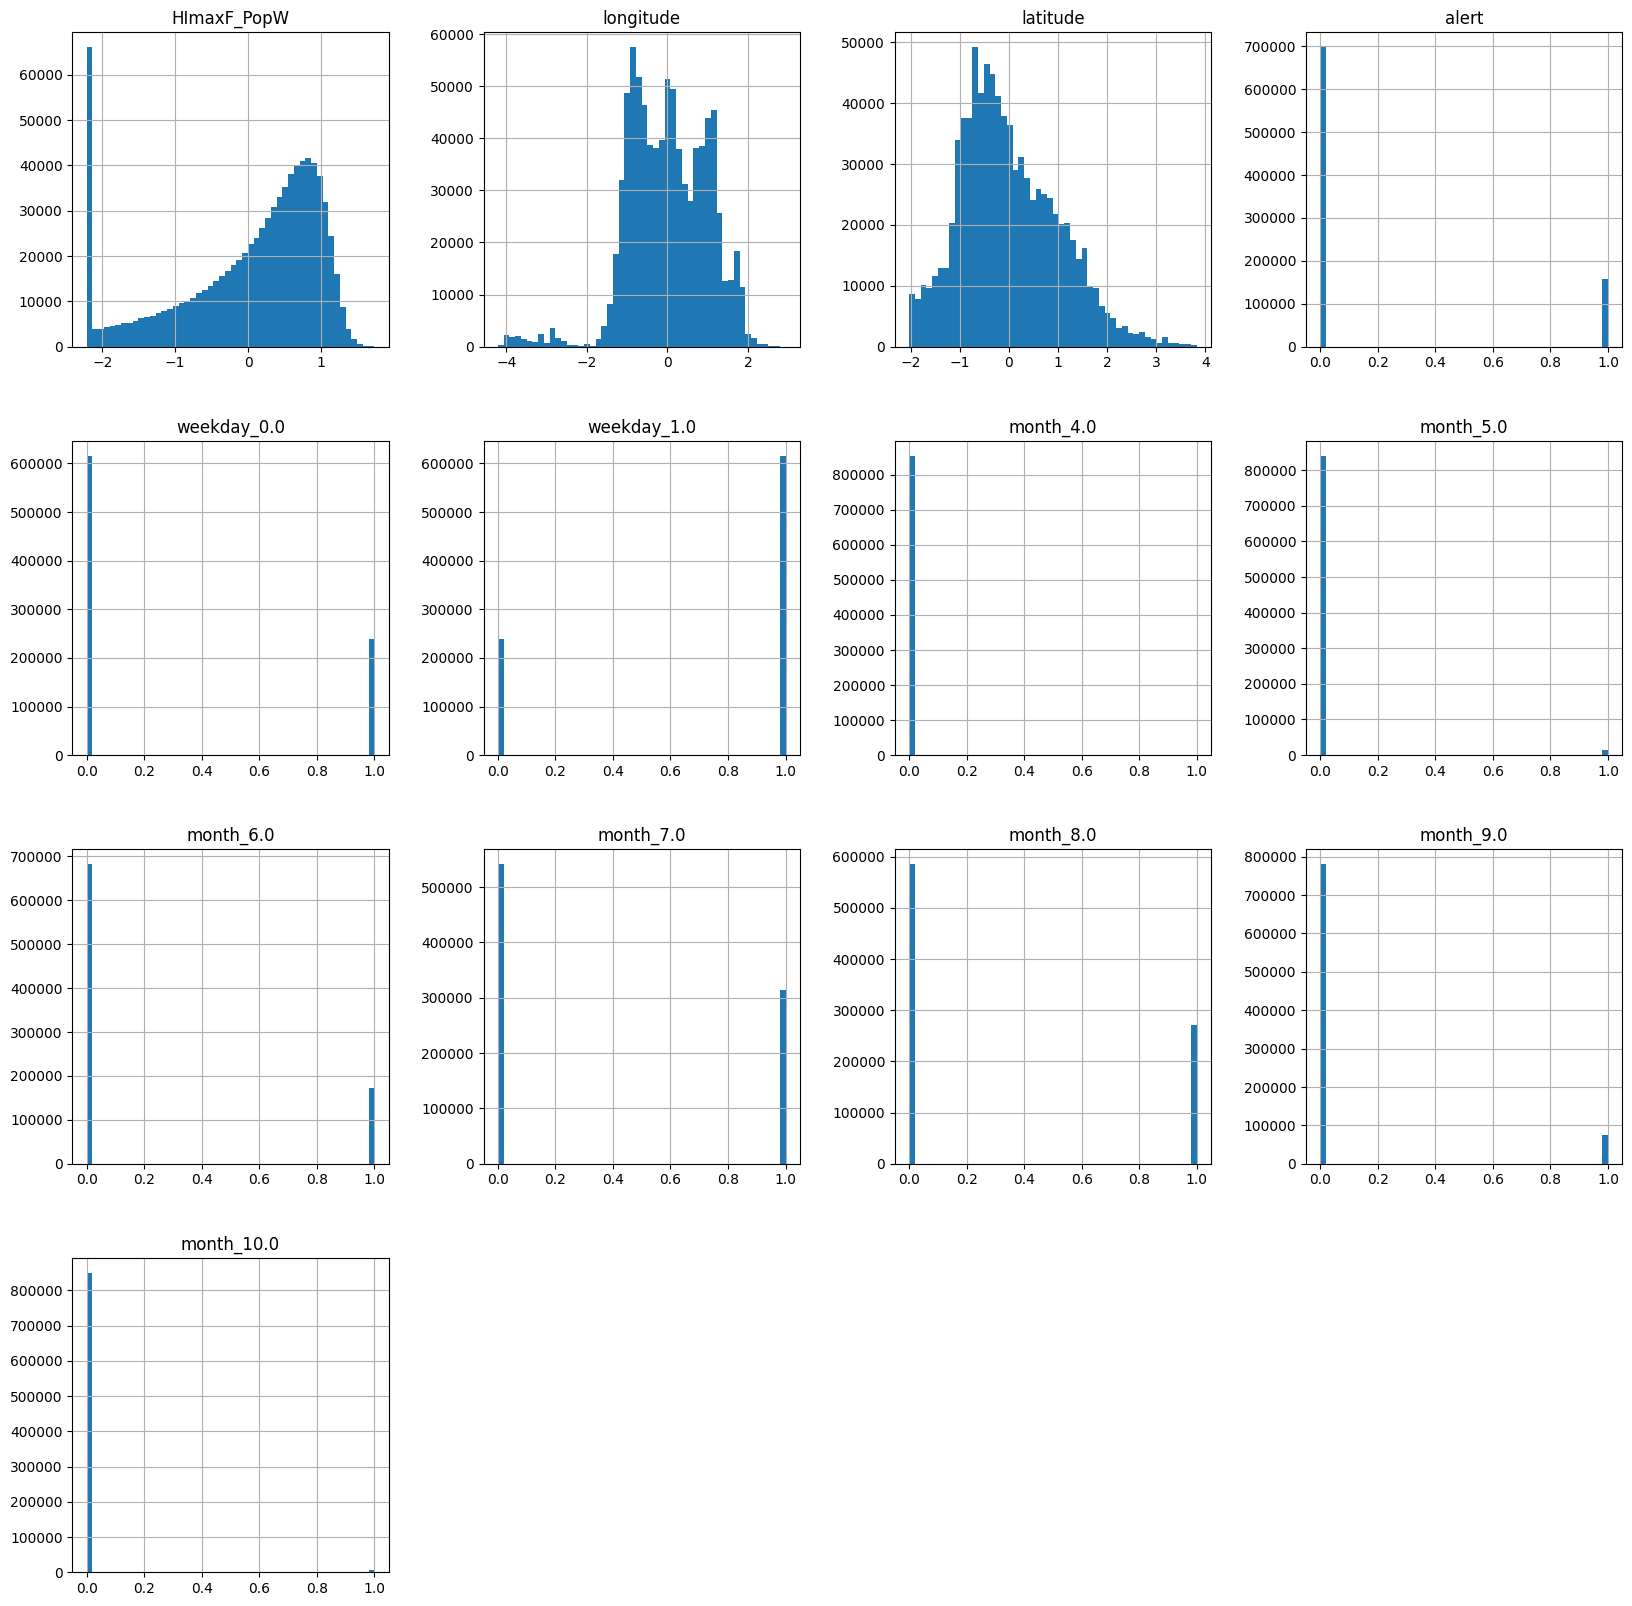

In [51]:
_ = data.hist(bins=50, figsize=(20,20))

In [55]:
#change the column order    
data = data[['longitude', 'latitude', 'HImaxF_PopW', 'weekday_0.0', 'weekday_1.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'alert']]

In [62]:
def set_seed(seed=2):
    np.random.seed(seed)
    torch.manual_seed(seed)

def split(df):
    set_seed()
    df = df.sample(frac=1)
    n = len(df)
    n_tr = int(n * 0.8)
    n_va = int(n * 0.1)

    train = df.iloc[: n_tr]
    valid = df.iloc[n_tr : n_tr + n_va]
    test = df.iloc[n_tr + n_va: ]

    return train, valid, test

train, valid, test = split(data)

In [63]:
train.shape, valid.shape, test.shape

((684016, 13), (85502, 13), (85503, 13))

Valid 0: 100%|██████████| 83/83 [00:00<00:00, 180.21it/s]


Log likilihood on validation: -350.62869372999813


Valid 1: 100%|██████████| 83/83 [00:00<00:00, 189.53it/s]


Log likilihood on validation: -338.4674208307841


Valid 2: 100%|██████████| 83/83 [00:00<00:00, 210.61it/s]


Log likilihood on validation: -334.99070022766847


Valid 3: 100%|██████████| 83/83 [00:00<00:00, 211.37it/s]


Log likilihood on validation: -333.4471472315041


Valid 4: 100%|██████████| 83/83 [00:00<00:00, 208.69it/s]


Log likilihood on validation: -332.6045157191265


Valid 5: 100%|██████████| 83/83 [00:00<00:00, 217.33it/s]


Log likilihood on validation: -332.11853725938914


Valid 6: 100%|██████████| 83/83 [00:00<00:00, 180.27it/s]


Log likilihood on validation: -331.7917792998164


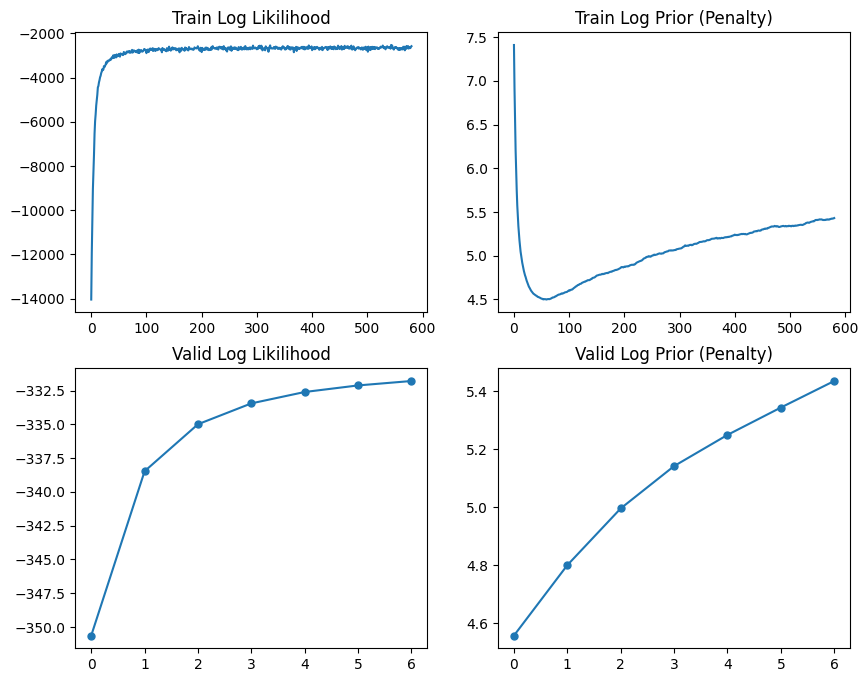

In [59]:
args = dict(
    batchsize = 8192,
    lamb = 0.5, # prior variance
    n_epochs = 7,
    lr = 1e-4,
    verbose=True,
)

def train_epoch(epoch, loader, model, optimizer, eval_dict, args):   
    lamb = args["lamb"]
    for batch in tqdm(loader, desc=f"Train {epoch}", disable=not args["verbose"]):
        X, y = batch[:, :-1].float(), batch[:, -1].long()
        logits = X @ model
        reg = 0.5 * lamb * (model**2).sum()
        # log likelihood
        LL = torch.sum(y * logits.sigmoid().log() + (1-y) * (-logits).sigmoid().log())
        (- reg - LL).backward()
        optimizer.step()
        optimizer.zero_grad()
        eval_dict["LL"].append(LL.item())
        eval_dict["penalty"].append(reg.item())
    return eval_dict
    
def eval_epoch(epoch, loader, model, prefix="Valid", args=None):
    lamb = args["lamb"]
    res = {"LL":[], "penalty":[]}
    for batch in tqdm(loader, desc=f"{prefix} {epoch}", disable=not args["verbose"]):
        X, y = batch[:, :-1].float(), batch[:, -1].long()
        logits = X @ model
        reg = 0.5 * lamb * (model**2).sum()
        LL = torch.sum(y * logits.sigmoid().log() + (1-y) * (-logits).sigmoid().log())
        res["LL"].append(LL.item())
        res["penalty"].append(reg.item())
    return res
    
def BayesLogistic(data, args):
    batchsize, n_epochs, lamb, lr, n_feat = args["batchsize"], args["n_epochs"], args["lamb"], args["lr"], data.shape[1] - 1 # number of input features
    
    set_seed()
    train_loader = torch.utils.data.DataLoader(train, batch_size=batchsize, shuffle=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=1024, drop_last=True)

    beta = nn.Parameter(torch.normal(mean=torch.zeros(n_feat), std=torch.ones(n_feat)/lamb))
    optimizer = torch.optim.SGD([beta], lr=lr)

    ## records
    train_ll = {"LL":[], "penalty":[]}
    valid_ll = {"LL":[], "penalty":[]}
    best = {"LL": -np.inf, "epoch":0, "model":[beta]}
    for epoch in range(n_epochs):
        train_epoch(epoch, train_loader, beta, optimizer, train_ll, args)
        res = eval_epoch(epoch, valid_loader, beta, "Valid", args)
        valid_ll["LL"].append(np.mean(res["LL"]))
        valid_ll["penalty"].append(np.mean(res["penalty"]))
        LL = np.mean(res["LL"]) # + np.mean(res["penalty"])
        if args["verbose"]:
            print(f"Log likilihood on validation: {LL}")
        if LL > best["LL"]:
            best["LL"] = np.mean(res["LL"]) + np.mean(res["penalty"])
            best["epoch"] = epoch
            best["model"] = copy.deepcopy(beta)

    ## plot
    train_ll = pd.DataFrame(train_ll)
    valid_ll = pd.DataFrame(valid_ll)
    if args["verbose"]:
        fig, axes = plt.subplots(2,2, figsize=(10,8))
        axes = axes.flatten()
        _ = train_ll.LL.plot(title="Train Log Likilihood", ax=axes[0])
        _ = train_ll.penalty.plot(title="Train Log Prior (Penalty)", ax=axes[1])

        _ = valid_ll.LL.plot(title="Valid Log Likilihood", ax=axes[2], ms=5, style="-o")
        _ = valid_ll.penalty.plot(title="Valid Log Prior (Penalty)", ax=axes[3], ms=5, style="-o")

    return valid_ll, best

t, best = BayesLogistic(data, args)

In [60]:
res = pd.DataFrame(best["model"].detach().numpy(), index=data.columns[:-1], columns=["coef"])
print(res.to_latex())

\begin{tabular}{lr}
\toprule
 & coef \\
\midrule
longitude & 0.161685 \\
latitude & 1.070970 \\
HImaxF_PopW & 2.240367 \\
weekday_0.0 & -2.138237 \\
weekday_1.0 & -2.178657 \\
month_4.0 & -1.294535 \\
month_5.0 & 0.660617 \\
month_6.0 & -0.663291 \\
month_7.0 & -0.439488 \\
month_8.0 & -0.433324 \\
month_9.0 & -0.785295 \\
month_10.0 & 1.227182 \\
\bottomrule
\end{tabular}



100%|██████████| 6/6 [1:41:15<00:00, 1012.53s/it]


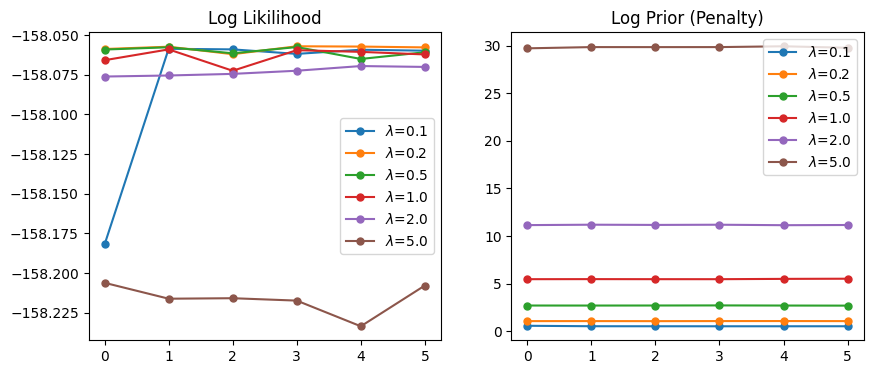

In [19]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for prior in tqdm([.1, .2, .5, 1., 2., 5.]):
    
    args = dict(
        batchsize = 4096,
        lamb = prior,
        n_epochs = 6,
        lr = 1e-4,
        verbose=False,
    )
    t, _  = main(data, args)
    LL, penalty = t.LL, t.penalty
    LL.name = f"$\lambda$={prior}"
    penalty.name = f"$\lambda$={prior}"
    LL.plot(title=f"Log Likilihood", ax=axes[0], ms=5, style="-o", legend=True)
    penalty.plot(title="Log Prior (Penalty)", ax=axes[1], ms=5, style="-o", legend=True)